In [1]:
from pathlib import Path
from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from typing import List
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss
import sys


sys.path.append("../")

from src.common_functions import *

In [2]:
# sample data
# RAW_DATA_PATH = "../datasets/fraud/vehicle_fraud.csv"
RAW_DATA_PATH = "C:/Users/stijn/OneDrive/Bureaublad/TEW 1ste jaar/python thesis/End-to-end-project---Customer-churn/datasets/fraud/vehicle_fraud.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem
df = pd.read_csv(RAW_DATA_PATH)
df = df.rename(columns=dict(zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
print(df.shape[0])
df["fraud_found_p"].value_counts()/df.shape[0]*100

pd.set_option('display.max_columns', None)

df.head()

15420


,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,policy_number,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,address_change_claim,number_of_cars,year,base_policy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [3]:
df.isna().any()

month                    False
week_of_month            False
day_of_week              False
make                     False
accident_area            False
day_of_week_claimed      False
month_claimed            False
week_of_month_claimed    False
sex                      False
marital_status           False
age                      False
fault                    False
policy_type              False
vehicle_category         False
vehicle_price            False
fraud_found_p            False
policy_number            False
rep_number               False
deductible               False
driver_rating            False
days_policy_accident     False
days_policy_claim        False
past_number_of_claims    False
age_of_vehicle           False
age_of_policy_holder     False
police_report_filed      False
witness_present          False
agent_type               False
number_of_suppliments    False
address_change_claim     False
number_of_cars           False
year                     False
base_pol

In [4]:
df.value_counts(["make", "fraud_found_p"])

make       fraud_found_p
Pontiac    0                3624
Toyota     0                2935
Honda      0                2622
Mazda      0                2231
Chevrolet  0                1587
Ford       0                 417
Accura     0                 413
VW         0                 275
Pontiac    1                 213
Toyota     1                 186
Honda      1                 179
Mazda      1                 123
Dodge      0                 107
Saab       0                  97
Chevrolet  1                  94
Mercury    0                  77
Accura     1                  59
Saturn     0                  52
Ford       1                  33
Nisson     0                  29
BMW        0                  14
Saab       1                  11
VW         1                   8
Mercury    1                   6
Jaguar     0                   6
Saturn     1                   6
Porche     0                   5
Mecedes    0                   3
Ferrari    0                   2
Dodge      1      

In [5]:
df[sorted(df.columns)].dtypes

accident_area            object
address_change_claim     object
age                       int64
age_of_policy_holder     object
age_of_vehicle           object
agent_type               object
base_policy              object
day_of_week              object
day_of_week_claimed      object
days_policy_accident     object
days_policy_claim        object
deductible                int64
driver_rating             int64
fault                    object
fraud_found_p             int64
make                     object
marital_status           object
month                    object
month_claimed            object
number_of_cars           object
number_of_suppliments    object
past_number_of_claims    object
police_report_filed      object
policy_number             int64
policy_type              object
rep_number                int64
sex                      object
vehicle_category         object
vehicle_price            object
week_of_month             int64
week_of_month_claimed     int64
witness_

In [6]:
df["fraud_found_p"].value_counts()/df.shape[0]*100

fraud_found_p
0    94.014267
1     5.985733
Name: count, dtype: float64

In [7]:
y = "fraud_found_p"

# some generic cleaning
df = df.loc[df.day_of_week_claimed!=0]
df = df.loc[df.policy_type!="Sport - Liability"]
df["vehicle_price"] = df["vehicle_price"].str.replace("less than ", "").str.replace("more than ", "").str.split(" to").str[0].astype(int)
df["past_number_of_claims"]= df["past_number_of_claims"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["days_policy_claim"] = df["days_policy_claim"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["days_policy_accident"] = df["days_policy_accident"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["age_of_vehicle"] = df["age_of_vehicle"].str.replace("new", "0").str.replace("more than ", "").str.split("").str[1].astype(int)
df["age_of_policy_holder"] = df["age_of_policy_holder"].str.replace("over ", "").str.split("").str[1:3].str.join("").astype(int)
df["address_change_claim"] = df["address_change_claim"].str.split("").str[1].str.replace("n", "0").str.replace("u", "0.25").astype(float)
df["number_of_suppliments"] = df["number_of_suppliments"].str.split("").str[1].str.replace("n", "0").str.replace("m", "5").astype(int)
df['number_of_cars'] = df.number_of_cars.str.split("").str[1].str.replace("m", "8")
df["number_of_cars_as_int"] = df["number_of_cars"].str.split("").str[1].str.replace("m", "8").astype(int)
COLUMNS_TO_DROP = ["address_change_claim", "number_of_cars", "policy_number"]
assert df[y].isna().any() == False
# drop single row with Lexus as encoder can't handle cases seen in only train, while encoding test
drop_condition = ((df.make.isin(["Lexus", "Ferrari", "Mecedes"])) | (
    df.make.isin(["BMW", "Nisson", "Mecedes", "Dodge"]) & (df[y] == 1)))
raw_features = df.drop(
    COLUMNS_TO_DROP, axis=1).loc[~drop_condition]

# ML tuning
# add make otherwise there are unknown brands in test set, and encoder can't handle
train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=raw_features[[y, "make"]])

fit_le = LabelEncoder().fit(train[y])

In [8]:
df.shape[0] - raw_features.shape[0]

11

In [9]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train['fraud_found_p']),
                                        y = train['fraud_found_p']                                                    
                                    )
class_weights = dict(zip(np.unique(train['fraud_found_p']), class_weights))
class_weights

{0: 0.5316139049426378, 1: 8.407912687585267}

In [10]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': list(range(6, 32, 8)),
    # 'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    # 'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
    'logistic__class_weight': [{0: 0.5316139049426378, 1: 8.407912687585267},{0:5,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

}

model = LogisticRegression()

MODEL_NAME = 'logistic'

# text_columns = ["address_change_claim"]

# steps = build_column_transformer_for_df(
#     train_x=train.drop(y, axis=1))._transformers
# steps.insert(0, ('text', TfidfVectorizer(), [text_column]))
# preprocessor = ColumnTransformer(steps)

# preprocessor = build_column_transformer_for_df(train.drop(y, axis=1), text_columns)
# pipeline = build_sklearn_pipeline(
#     train, y_col_name=y, model_name=MODEL_NAME, model=model, transformer=preprocessor)
grid = sklearn_gridsearch_using_pipeline(train, y_col_name=y, model_name=MODEL_NAME,
                                  model=model, fit_le=fit_le, param_grid=param_grid, verbose=1, n_folds=5, step_names_to_remove=['under', 'over']) #, pipeline=pipeline)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best score: 0.773791776305175
Best parameters: {'logistic__C': 10, 'logistic__class_weight': {0: 5, 1: 1}, 'logistic__penalty': 'l2', 'pca__n_components': 22}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['week_of_month',
                                                   'week_of_month_claimed',
                                                   'age', 'vehicle_price',
                                                   'rep_number', 'deductible',
                                                   'driver_rating',
                                                   'days_policy_accident',
                                                   'days_policy_claim',
                                                   'past_number_of_claims',
                                                   'age_of_vehi...
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['month', 'day_of_week',
                                                   'make', 'accident_area',
                                                   'day_of_week_claimed',
                                                   'month_claimed', 'sex',
                                                   'marital_status', 'fault',
                                                   'policy_type',
                                                   'vehicle_category',
                                                   'police_report_filed',
                                                   'witness_present',
                                                   'agent_type',
                                                   'base_policy'])])),
                ('pca', PCA(n_components=22)),
                ('logistic',
                 LogisticRegression(C=10, class_weight={0: 5, 1: 1}))])

In [11]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [12]:
COLUMNS = ["pca__n_components", "logistic__class_weight", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS] #.sort_values(by=COLUMNS)

,pca__n_components,logistic__class_weight,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,6,"{0: 0.5316139049426378, 1: 8.407912687585267}",1,l2,0.625427,0.015004
1,14,"{0: 0.5316139049426378, 1: 8.407912687585267}",1,l2,0.623010,0.016918
2,22,"{0: 0.5316139049426378, 1: 8.407912687585267}",1,l2,0.770500,0.004640
3,30,"{0: 0.5316139049426378, 1: 8.407912687585267}",1,l2,0.767714,0.007438
4,6,"{0: 5, 1: 1}",1,l2,0.628485,0.014720
...,...,...,...,...,...,...
75,30,"{0: 1, 1: 10}",1000,l2,0.769095,0.006941
76,6,"{0: 1, 1: 100}",1000,l2,0.620834,0.015836
77,14,"{0: 1, 1: 100}",1000,l2,0.613797,0.016972
78,22,"{0: 1, 1: 100}",1000,l2,0.764499,0.008188


In [13]:
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [14]:
# To check if categorical values are in train but not in test 
categorical_columns = train.select_dtypes(
    include='object').columns.to_list()

for feature in categorical_columns:
    diff = set(train[feature]).difference(test[feature])
    if len(diff)>0:
        print(feature)

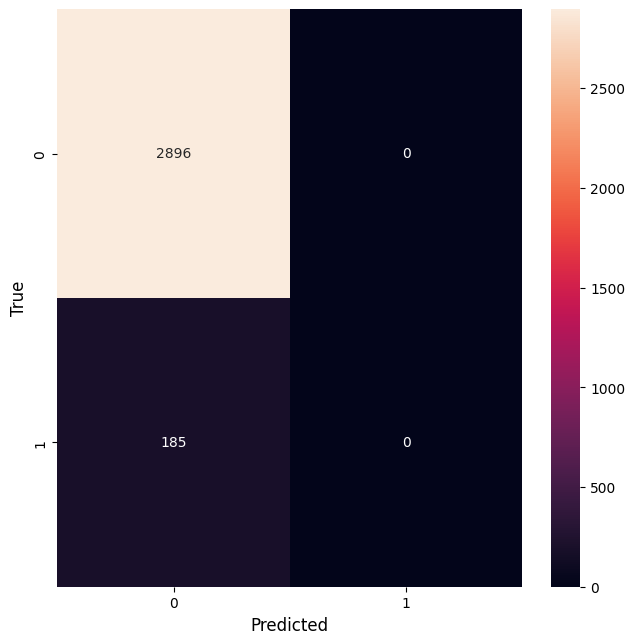

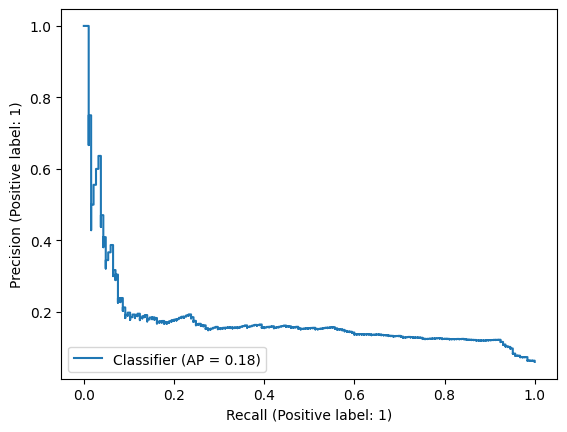

In [15]:
# one case can't get fixed, won't affect results
fixed_test_set = test.reset_index(drop=True).drop(1136, axis=0)

evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=fixed_test_set, y_col_name=y, model_name= 'logistic')

In [16]:
num_positive = np.sum(train == 1)
num_negative = np.sum(train == 0)
scale_pos_weight = num_negative / num_positive
print(scale_pos_weight)

month                          NaN
week_of_month             0.000000
day_of_week                    NaN
make                           NaN
accident_area                  NaN
day_of_week_claimed            NaN
month_claimed                  NaN
week_of_month_claimed     0.000000
sex                            NaN
marital_status                 NaN
age                            inf
fault                          NaN
policy_type                    NaN
vehicle_category               NaN
vehicle_price                  NaN
fraud_found_p            15.815825
rep_number                0.000000
deductible                     NaN
driver_rating             0.000000
days_policy_accident      3.727273
days_policy_claim              NaN
past_number_of_claims     1.238432
age_of_vehicle                 inf
age_of_policy_holder           NaN
police_report_filed            NaN
witness_present                NaN
agent_type                     NaN
number_of_suppliments     2.784470
year                

In [17]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    # 'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    # 'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
    'xgb__scale_pos_weight':[ 1,5, 10,15.815825, 50, 75, 100,  1000]

}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized = True, step_names_to_remove=['under', 'over'])
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best score: 0.7756298897307954
Best parameters: {'xgb__subsample': 1.0, 'xgb__scale_pos_weight': 5, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 10, 'xgb__max_depth': 4, 'xgb__gamma': 0.5, 'xgb__colsample_bytree': 0.6, 'pca__n_components': 30}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['week_of_month',
                                                   'week_of_month_claimed',
                                                   'age', 'vehicle_price',
                                                   'rep_number', 'deductible',
                                                   'driver_rating',
                                                   'days_policy_accident',
                                                   'days_policy_claim',
                                                   'past_number_of_claims',
                                                   'age_of_vehi...
                               feature_types=None, gamma=0.5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [18]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

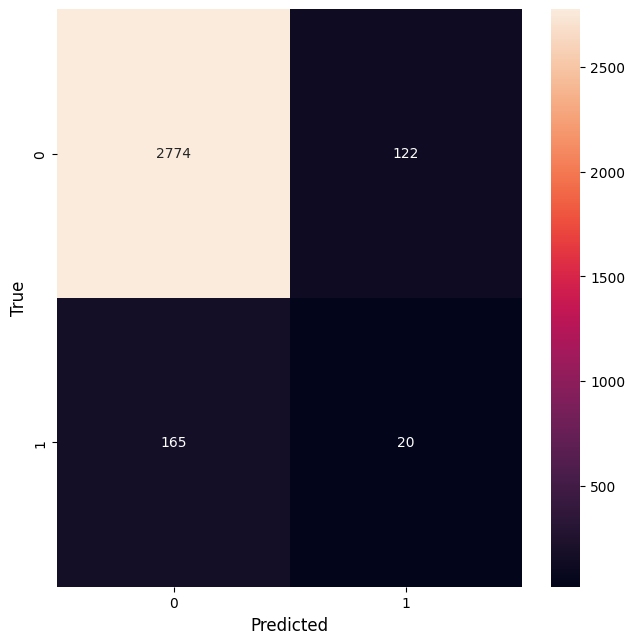

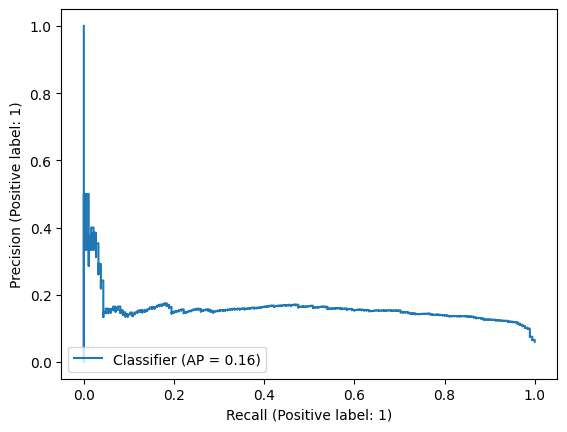

In [19]:
# one case can't get fixed, won't affect results
fixed_test_set = test.reset_index(drop=True).drop(1136, axis=0)


evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=fixed_test_set, y_col_name=y, model_name=MODEL_NAME)

In [20]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)
MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# evaluation metrics

In [21]:
test = fixed_test_set

In [22]:
test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log["churn_encoded"] = fit_le.transform(test_predictions_log["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test["vehicle_price"].to_frame()))[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 2860.
 total cost/loss average :  0.9281077572216813


In [23]:
print(test['vehicle_price'].unique())

[69000 30000 20000 40000 60000]


In [24]:
print(test["fraud_found_p"].unique())

[0 1]


In [25]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["vehicle_price"].to_frame()))[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 2648.
 total cost/loss average :  0.8596234988640052


In [26]:
print(test_predictions_xgb[['fraud_found_p', "A", 'instance_cost', 'y_predicted']].iloc[31:60])

    fraud_found_p        A  instance_cost  y_predicted
31              0  20000.0            0.0            0
32              0  20000.0            0.0            0
33              0  30000.0            0.0            0
34              0  60000.0            0.0            0
35              0  30000.0            0.0            0
36              0  20000.0            0.0            0
37              0  69000.0            0.0            0
38              0  20000.0            0.0            0
39              0  20000.0            0.0            0
40              0  20000.0            0.0            0
41              0  30000.0            0.0            0
42              0  20000.0            0.0            0
43              0  20000.0            0.0            0
44              0  20000.0            1.0            1
45              0  20000.0            0.0            0
46              0  69000.0            0.0            0
47              1  30000.0           15.0            0
48        

# amc metric

Decision Threshold: 0.01, Test cost/loss = 1600.00
Decision Threshold: 0.02, Test cost/loss = 1778.50
Decision Threshold: 0.03, Test cost/loss = 2128.00
Decision Threshold: 0.04, Test cost/loss = 2438.50
Decision Threshold: 0.05, Test cost/loss = 2595.50
Decision Threshold: 0.06, Test cost/loss = 2679.50
Decision Threshold: 0.07, Test cost/loss = 2693.50
Decision Threshold: 0.08, Test cost/loss = 2790.50
Decision Threshold: 0.09, Test cost/loss = 2825.00
Decision Threshold: 0.10, Test cost/loss = 2825.00
Decision Threshold: 0.11, Test cost/loss = 2825.00
Decision Threshold: 0.12, Test cost/loss = 2859.50
Decision Threshold: 0.13, Test cost/loss = 2859.50
Decision Threshold: 0.14, Test cost/loss = 2859.50
Decision Threshold: 0.15, Test cost/loss = 2859.50
Decision Threshold: 0.16, Test cost/loss = 2859.50
Decision Threshold: 0.17, Test cost/loss = 2859.50
Decision Threshold: 0.18, Test cost/loss = 2859.50
Decision Threshold: 0.19, Test cost/loss = 2859.50
Decision Threshold: 0.20, Test 

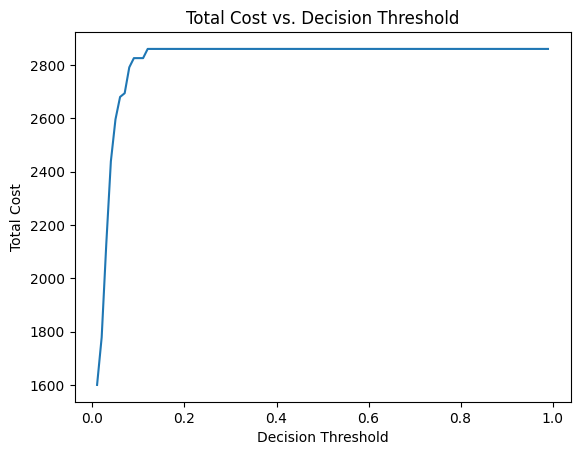

In [27]:
cb_column = 'A'
test_predictions_log['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud')

Decision Threshold: 0.01, Test cost/loss = 2055.50
Decision Threshold: 0.02, Test cost/loss = 1743.50
Decision Threshold: 0.03, Test cost/loss = 1623.00
Decision Threshold: 0.04, Test cost/loss = 1519.00
Decision Threshold: 0.05, Test cost/loss = 1474.50
Decision Threshold: 0.06, Test cost/loss = 1452.50
Decision Threshold: 0.07, Test cost/loss = 1458.00
Decision Threshold: 0.08, Test cost/loss = 1465.00
Decision Threshold: 0.09, Test cost/loss = 1435.00
Decision Threshold: 0.10, Test cost/loss = 1464.00
Decision Threshold: 0.11, Test cost/loss = 1502.00
Decision Threshold: 0.12, Test cost/loss = 1540.00
Decision Threshold: 0.13, Test cost/loss = 1558.50
Decision Threshold: 0.14, Test cost/loss = 1581.00
Decision Threshold: 0.15, Test cost/loss = 1608.00
Decision Threshold: 0.16, Test cost/loss = 1638.50
Decision Threshold: 0.17, Test cost/loss = 1619.50
Decision Threshold: 0.18, Test cost/loss = 1610.50
Decision Threshold: 0.19, Test cost/loss = 1696.00
Decision Threshold: 0.20, Test 

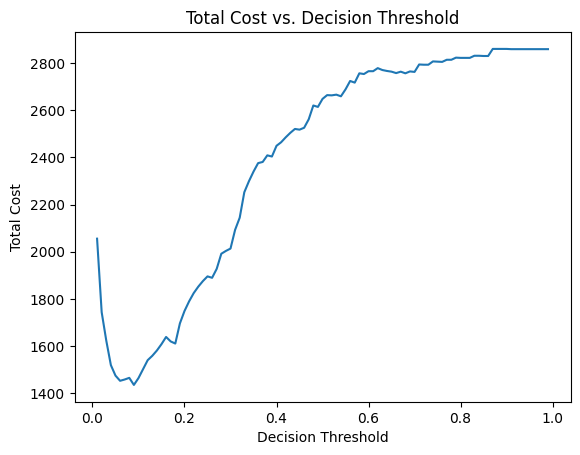

In [28]:
test_predictions_xgb['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'fraud' )

# e-amc

In [29]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="fraud")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [30]:
test_predictions_log

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,0,0,69000.0,0.0,0,0.035759,0,34.5,1,0,0.035759,0.059468
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,0,0,30000.0,0.0,0,0.023387,0,15.0,1,0,0.023387,0.059468
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,0,0,20000.0,0.0,0,0.003143,0,10.0,1,0,0.003143,0.059468
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,0,0,30000.0,0.0,0,0.013175,0,15.0,1,0,0.013175,0.059468
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,0,0,20000.0,0.0,0,0.023642,0,10.0,1,0,0.023642,0.059468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,Nov,2,Tuesday,Toyota,Urban,Wednesday,Nov,2,Male,Married,48,Policy Holder,Sedan - All Perils,Sedan,20000,1,9,400,4,30,30,1,7,41,No,No,External,0,1995,All Perils,1,0,1,20000.0,10.0,0,0.036718,0,10.0,1,0,9.632815,9.405322
3054,May,4,Tuesday,Chevrolet,Urban,Friday,May,4,Male,Married,77,Policy Holder,Sedan - Collision,Sedan,20000,1,13,400,4,30,30,2,7,65,No,No,External,3,1996,Collision,1,0,1,20000.0,10.0,0,0.008837,0,10.0,1,0,9.911629,9.405322
3057,Dec,2,Sunday,Mazda,Urban,Monday,Dec,2,Female,Married,33,Policy Holder,Sedan - Liability,Sport,20000,1,3,400,1,30,30,4,7,31,Yes,No,External,0,1995,Liability,1,0,1,20000.0,10.0,0,0.002144,0,10.0,1,0,9.978564,9.405322
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,0,1,30000.0,15.0,0,0.030294,0,15.0,1,0,14.545593,14.107983


In [31]:
test_predictions_xgb

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,0,0,69000.0,0.0,0,0.060218,0,34.5,1,0,0.060218,0.059468
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,0,0,30000.0,0.0,0,0.212132,0,15.0,1,0,0.212132,0.059468
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,0,0,20000.0,0.0,0,0.009489,0,10.0,1,0,0.009489,0.059468
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,0,0,30000.0,0.0,0,0.101276,0,15.0,1,0,0.101276,0.059468
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,0,0,20000.0,0.0,0,0.243698,0,10.0,1,0,0.243698,0.059468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,Nov,2,Tuesday,Toyota,Urban,Wednesday,Nov,2,Male,Married,48,Policy Holder,Sedan - All Perils,Sedan,20000,1,9,400,4,30,30,1,7,41,No,No,External,0,1995,All Perils,1,0,1,20000.0,10.0,0,0.268171,0,10.0,1,0,7.318292,9.405322
3054,May,4,Tuesday,Chevrolet,Urban,Friday,May,4,Male,Married,77,Policy Holder,Sedan - Collision,Sedan,20000,1,13,400,4,30,30,2,7,65,No,No,External,3,1996,Collision,1,0,1,20000.0,10.0,0,0.051196,0,10.0,1,0,9.488042,9.405322
3057,Dec,2,Sunday,Mazda,Urban,Monday,Dec,2,Female,Married,33,Policy Holder,Sedan - Liability,Sport,20000,1,3,400,1,30,30,4,7,31,Yes,No,External,0,1995,Liability,1,0,1,20000.0,10.0,0,0.005426,0,10.0,1,0,9.945742,9.405322
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,0,1,30000.0,15.0,0,0.299553,0,15.0,1,0,10.506706,14.107983


In [32]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

2813.1009989247946
2861.6705743955863
EAP :  0.9130480360028544
EP :  0.9288122604334912


In [33]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

2391.0148651929194
2861.6705743955863
EAP :  0.7760515628669001
EP :  0.9288122604334912


# MP at 50%threshold

In [34]:
test_predictions_log_2= test.copy(deep=True)
test_predictions_log_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_2.drop(y, axis=1))
test_predictions_log_2["churn_encoded"] = fit_le.transform(test_predictions_log_2["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_2['A'] = impute.fit_transform(
    (test_predictions_log_2["vehicle_price"].to_frame()))[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_2['instance_cost'] = test_predictions_log_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_2[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_2['instance_cost'].sum()/len(test_predictions_log_2))

Test cost/loss = -2860.
 total cost/loss average :  -0.9281077572216813


In [35]:
test_predictions_log_2

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,0,0,69000.0,0.0,0
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,0,0,30000.0,0.0,0
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,0,0,20000.0,0.0,0
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,0,0,30000.0,0.0,0
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,0,0,20000.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,Feb,3,Wednesday,Pontiac,Urban,Thursday,Feb,3,Male,Married,32,Third Party,Sedan - All Perils,Sedan,20000,0,8,400,2,30,30,0,7,31,No,No,External,0,1996,All Perils,3,0,0,20000.0,0.0,0
3078,Oct,3,Monday,Mazda,Urban,Tuesday,Oct,3,Male,Single,30,Third Party,Sedan - Collision,Sedan,20000,0,1,400,3,30,30,1,6,31,No,No,External,1,1996,Collision,1,0,0,20000.0,0.0,0
3079,Jun,2,Monday,Honda,Urban,Tuesday,Jun,4,Male,Married,26,Policy Holder,Sedan - Liability,Sport,30000,0,11,400,4,30,30,2,7,31,No,No,External,0,1996,Liability,1,0,0,30000.0,0.0,0
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,0,1,30000.0,-15.0,0


In [36]:
test_predictions_xgb_2 = test.copy(deep=True)
test_predictions_xgb_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_2.drop(y, axis=1))
test_predictions_xgb_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_2["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_2['A'] = impute.fit_transform(
    (test_predictions_xgb_2["vehicle_price"].to_frame()))[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_2['instance_cost'] = test_predictions_xgb_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_2[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_2['instance_cost'].sum()/len(test_predictions_xgb_2))

Test cost/loss = -2628.
 total cost/loss average :  -0.853132099967543


In [37]:
test_predictions_xgb_2

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,0,0,69000.0,0.0,0
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,0,0,30000.0,0.0,0
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,0,0,20000.0,0.0,0
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,0,0,30000.0,0.0,0
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,0,0,20000.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,Feb,3,Wednesday,Pontiac,Urban,Thursday,Feb,3,Male,Married,32,Third Party,Sedan - All Perils,Sedan,20000,0,8,400,2,30,30,0,7,31,No,No,External,0,1996,All Perils,3,0,0,20000.0,0.0,0
3078,Oct,3,Monday,Mazda,Urban,Tuesday,Oct,3,Male,Single,30,Third Party,Sedan - Collision,Sedan,20000,0,1,400,3,30,30,1,6,31,No,No,External,1,1996,Collision,1,0,0,20000.0,0.0,0
3079,Jun,2,Monday,Honda,Urban,Tuesday,Jun,4,Male,Married,26,Policy Holder,Sedan - Liability,Sport,30000,0,11,400,4,30,30,2,7,31,No,No,External,0,1996,Liability,1,0,0,30000.0,0.0,0
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,0,1,30000.0,-15.0,0


# MP metric

Decision Threshold: 0.01, Test cost/loss = -1436.00
Decision Threshold: 0.02, Test cost/loss = -1653.50
Decision Threshold: 0.03, Test cost/loss = -2064.00
Decision Threshold: 0.04, Test cost/loss = -2410.50


Decision Threshold: 0.05, Test cost/loss = -2581.50
Decision Threshold: 0.06, Test cost/loss = -2670.50
Decision Threshold: 0.07, Test cost/loss = -2686.50
Decision Threshold: 0.08, Test cost/loss = -2788.50
Decision Threshold: 0.09, Test cost/loss = -2824.00
Decision Threshold: 0.10, Test cost/loss = -2824.00
Decision Threshold: 0.11, Test cost/loss = -2824.00
Decision Threshold: 0.12, Test cost/loss = -2859.50
Decision Threshold: 0.13, Test cost/loss = -2859.50
Decision Threshold: 0.14, Test cost/loss = -2859.50
Decision Threshold: 0.15, Test cost/loss = -2859.50
Decision Threshold: 0.16, Test cost/loss = -2859.50
Decision Threshold: 0.17, Test cost/loss = -2859.50
Decision Threshold: 0.18, Test cost/loss = -2859.50
Decision Threshold: 0.19, Test cost/loss = -2859.50
Decision Threshold: 0.20, Test cost/loss = -2859.50
Decision Threshold: 0.21, Test cost/loss = -2859.50
Decision Threshold: 0.22, Test cost/loss = -2859.50
Decision Threshold: 0.23, Test cost/loss = -2859.50
Decision Thr

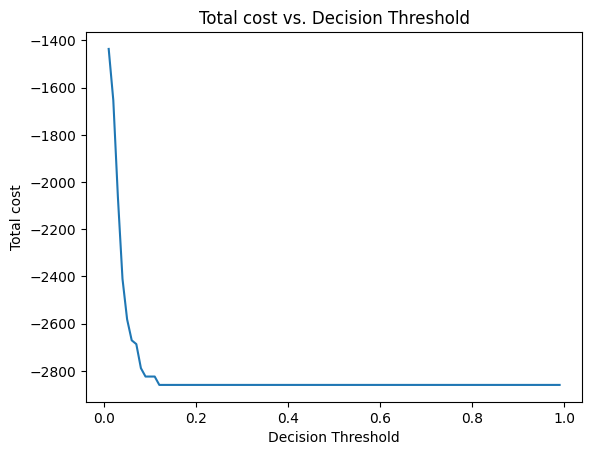

In [38]:
cb_column = 'A'
test_predictions_log_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud_2')

Decision Threshold: 0.01, Test cost/loss = -1872.50
Decision Threshold: 0.02, Test cost/loss = -1560.50
Decision Threshold: 0.03, Test cost/loss = -1442.00
Decision Threshold: 0.04, Test cost/loss = -1341.00
Decision Threshold: 0.05, Test cost/loss = -1298.50
Decision Threshold: 0.06, Test cost/loss = -1280.50
Decision Threshold: 0.07, Test cost/loss = -1289.00
Decision Threshold: 0.08, Test cost/loss = -1300.00
Decision Threshold: 0.09, Test cost/loss = -1272.00
Decision Threshold: 0.10, Test cost/loss = -1304.00
Decision Threshold: 0.11, Test cost/loss = -1345.00
Decision Threshold: 0.12, Test cost/loss = -1389.00
Decision Threshold: 0.13, Test cost/loss = -1411.50
Decision Threshold: 0.14, Test cost/loss = -1438.00
Decision Threshold: 0.15, Test cost/loss = -1470.00
Decision Threshold: 0.16, Test cost/loss = -1504.50
Decision Threshold: 0.17, Test cost/loss = -1486.50
Decision Threshold: 0.18, Test cost/loss = -1480.50
Decision Threshold: 0.19, Test cost/loss = -1570.00
Decision Thr

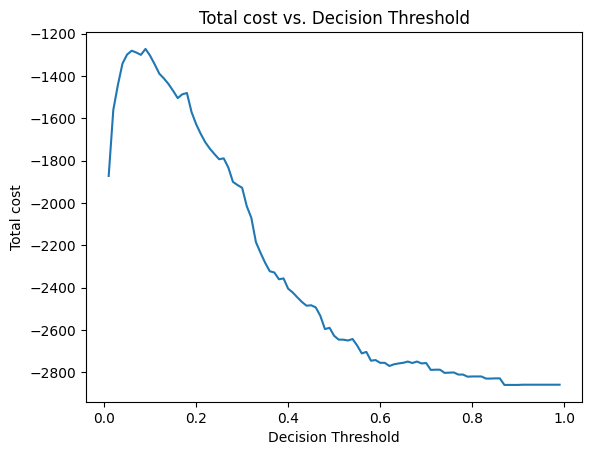

In [39]:
test_predictions_xgb_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'fraud_2' )

# E-MP metric

In [40]:
test_predictions_log_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="fraud_2")
test_predictions_xgb_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [41]:
print(test_predictions_log_2['EAP'].sum())
print(test_predictions_log_2['EP'].sum())


print('EAP : ', test_predictions_log_2['EAP'].sum()/len(test_predictions_log_2))
print('EP : ', test_predictions_log_2['EP'].sum()/len(test_predictions_log_2))

-2808.0234878477017
-2850.6690329385037
EAP :  -0.9114000285127237
EP :  -0.9252414907297968


In [42]:
print(test_predictions_xgb_2['EAP'].sum())
print(test_predictions_xgb_2['EP'].sum())


print('EAP : ', test_predictions_xgb_2['EAP'].sum()/len(test_predictions_xgb_2))
print('EP : ', test_predictions_xgb_2['EP'].sum()/len(test_predictions_xgb_2))

-2337.390177986221
-2850.6690329385037
EAP :  -0.7586466010990655
EP :  -0.9252414907297968


In [43]:
len(test_predictions_log['FP'])

3081

In [44]:
test_predictions_log_2

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,0,0,69000.0,0.0,0,0.035759,0,-34.5,-1,1,-0.035759,-0.059468
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,0,0,30000.0,0.0,0,0.023387,0,-15.0,-1,1,-0.023387,-0.059468
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,0,0,20000.0,0.0,0,0.003143,0,-10.0,-1,1,-0.003143,-0.059468
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,0,0,30000.0,0.0,0,0.013175,0,-15.0,-1,1,-0.013175,-0.059468
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,0,0,20000.0,0.0,0,0.023642,0,-10.0,-1,1,-0.023642,-0.059468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,Nov,2,Tuesday,Toyota,Urban,Wednesday,Nov,2,Male,Married,48,Policy Holder,Sedan - All Perils,Sedan,20000,1,9,400,4,30,30,1,7,41,No,No,External,0,1995,All Perils,1,0,1,20000.0,-10.0,0,0.036718,0,-10.0,-1,1,-9.596097,-9.345854
3054,May,4,Tuesday,Chevrolet,Urban,Friday,May,4,Male,Married,77,Policy Holder,Sedan - Collision,Sedan,20000,1,13,400,4,30,30,2,7,65,No,No,External,3,1996,Collision,1,0,1,20000.0,-10.0,0,0.008837,0,-10.0,-1,1,-9.902792,-9.345854
3057,Dec,2,Sunday,Mazda,Urban,Monday,Dec,2,Female,Married,33,Policy Holder,Sedan - Liability,Sport,20000,1,3,400,1,30,30,4,7,31,Yes,No,External,0,1995,Liability,1,0,1,20000.0,-10.0,0,0.002144,0,-10.0,-1,1,-9.976420,-9.345854
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,0,1,30000.0,-15.0,0,0.030294,0,-15.0,-1,1,-14.515299,-14.048515


# cost-curves

In [45]:
total_fp_log = 0

for i in range(0,3081):
    if test_predictions_log['churn_encoded'].iloc[i] == 0 and test_predictions_log['y_predicted'].iloc[i]==1:
        total_fp_log += test_predictions_log['FP'].iloc[i]
    else:
        total_fp_log += 0

print(total_fp_log)

average_fp_log = total_fp_log/3081
print( average_fp_log)

0
0.0


In [46]:
total_fn_log = 0

for i in range(0,3081):
    if test_predictions_log['churn_encoded'].iloc[i] == 1 and test_predictions_log['y_predicted'].iloc[i]==0:
        total_fn_log += test_predictions_log['FN'].iloc[i]
    else:
        total_fn_log += 0

print(total_fn_log)

average_fn_log = total_fn_log/3081
print( average_fn_log)

2859.5
0.9281077572216813


C:\Users\stijn\AppData\Local\Temp\ipykernel_24376\1858829342.py:32: RuntimeWarning: invalid value encountered in divide
  pc = (thresholds*cost_fn_log) / (thresholds*cost_fn_log + (1-thresholds)*cost_fp_log)
C:\Users\stijn\AppData\Local\Temp\ipykernel_24376\1858829342.py:60: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim([0.0, 1.05*max(lower_envelope)])


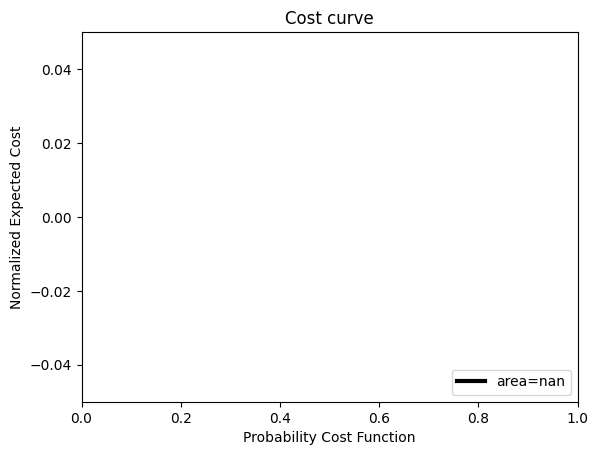

In [47]:
# C(-|+)
cost_fn_log = average_fn_log
# C(+|-)
cost_fp_log = average_fp_log

# Ground truth
truth = test_predictions_log['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log) / (thresholds*cost_fn_log + (1-thresholds)*cost_fp_log)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [48]:
total_fp_xgb = 0

for i in range(0,3081):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 0 and test_predictions_xgb['y_predicted'].iloc[i]==1:
        total_fp_xgb += test_predictions_xgb['FP'].iloc[i]
    else:
        total_fp_xgb += 0

print(total_fp_xgb)

average_fp_xgb = total_fp_xgb/3081
print( average_fp_xgb)

122
0.039597533268419347


In [49]:
total_fn_xgb = 0

for i in range(0,3081):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 1 and test_predictions_xgb['y_predicted'].iloc[i]==0:
        total_fn_xgb += test_predictions_xgb['FN'].iloc[i]
    else:
        total_fn_xgb += 0

print(total_fn_xgb)

average_fn_xgb = total_fn_xgb/3081
print( average_fn_xgb)

2526.5
0.8200259655955858


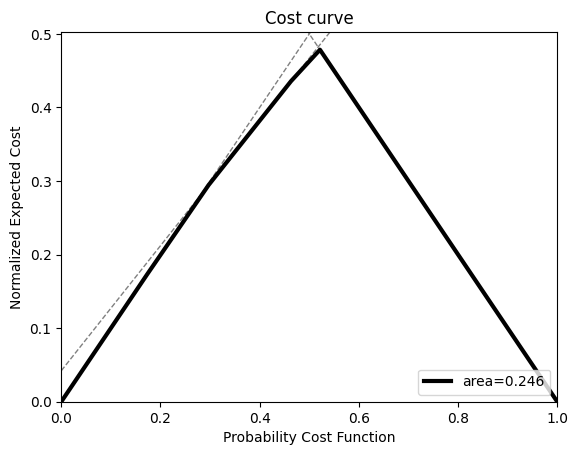

In [50]:
# C(-|+)
cost_fn_xgb = average_fn_xgb
# C(+|-)
cost_fp_xgb = average_fp_xgb

# Ground truth
truth = test_predictions_xgb['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb) / (thresholds*cost_fn_xgb + (1-thresholds)*cost_fp_xgb)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

# from here on we calculate the amc, e-amc, mp and emp but with the churn prediction cost and benefit matrices

# total cost at 50% threshold